In [1]:
import sys
print(sys.version)

3.8.6 (tags/v3.8.6:db45529, Sep 23 2020, 15:52:53) [MSC v.1927 64 bit (AMD64)]


In [2]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import make_grid
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from util import CLASS_NAME_TO_ID, visualize, save_model  # 직접 만든 util.py에서 가져옴
from collections import defaultdict
from torchvision.ops import nms

In [3]:
data_dir = './DataSet/'
data_df = pd.read_csv(os.path.join(data_dir, 'df.csv'))
data_df

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24057,fff2b15ad6007d0e,activemil,Truck,1,0.277344,0.622656,0.226389,0.859722,0,0,...,0,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
24058,fff376d20410e4c9,xclick,Bus,1,0.295625,0.558750,0.306667,0.397500,1,0,...,1,0,0.424375,0.316250,0.295625,0.558750,0.306667,0.397500,0.382500,0.335833
24059,fff376d20410e4c9,xclick,Bus,1,0.348125,0.701250,0.423333,0.744167,0,0,...,1,0,0.478750,0.493125,0.348125,0.701250,0.423333,0.744167,0.537500,0.523333
24060,fffde5953a818927,xclick,Bus,1,0.277500,0.605625,0.565000,0.795833,0,0,...,0,0,0.488125,0.277500,0.517500,0.605625,0.565000,0.670000,0.795833,0.704167


In [4]:
index = 0
image_files = [fn for fn in os.listdir('./DataSet/train/') if fn.endswith('jpg')]
image_file = image_files[index]
image_file

'0000599864fd15b3.jpg'

In [5]:
image_path = os.path.join('./DataSet/train/', image_file)
image_path

'./DataSet/train/0000599864fd15b3.jpg'

In [6]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape

(170, 256, 3)

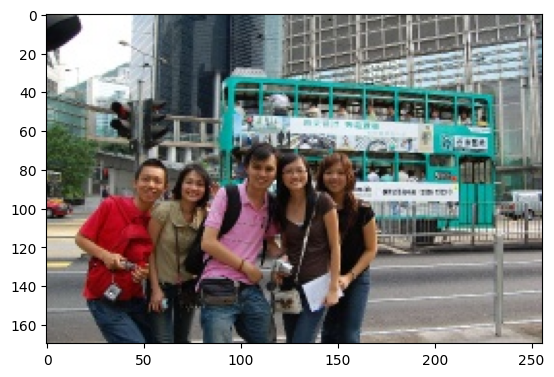

In [7]:
plt.imshow(image)

In [8]:
image_id = image_file.split('.')[0]
image_id

'0000599864fd15b3'

In [9]:
meta_data = data_df[data_df['ImageID'] == image_id]
meta_data

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.34375,0.90875,0.156162,0.650047,1,0,...,0,0,0.421875,0.34375,0.795,0.90875,0.156162,0.5127,0.650047,0.457197


In [10]:
cate_names = meta_data['LabelName'].values
cate_names

array(['Bus'], dtype=object)

In [11]:
bboxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
bboxes

array([[0.34375 , 0.90875 , 0.156162, 0.650047]])

In [12]:
img_H, img_W, _ = image.shape
img_H, img_W

(170, 256)

In [13]:
class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]
class_ids

[0]

In [14]:
# 'XMin', 'XMax', 'YMin', 'YMax'
unnorm_bboxes = bboxes.copy()
# unnorm_bboxes

# XMax, YMin의 자리를 바꿈
# 'XMin', 'YMin', 'XMax', 'YMax'
unnorm_bboxes[:, [1, 2]] = unnorm_bboxes[:, [2, 1]]

# 'XMin', 'YMin' -= 'XMin', 'YMin'
# 'XMax' - 'XMin' , 'YMax' - 'YMin'
# 'XMin', 'YMin', W, H
unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]

# 'XMin', 'YMin' += (W, H / 2)
# 'XMin' + (W / 2), 'YMin' + (H / 2)
# X_Cen, Y_Cen, W, H
unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4]/2)

# X_cen, Y_cen, W, H
unnorm_bboxes

array([[0.62625  , 0.4031045, 0.565    , 0.493885 ]])

In [15]:
unnorm_bboxes[:, [0, 2]] *= img_W
unnorm_bboxes[:, [1, 3]] *= img_H
unnorm_bboxes

array([[160.32    ,  68.527765, 144.64    ,  83.96045 ]])

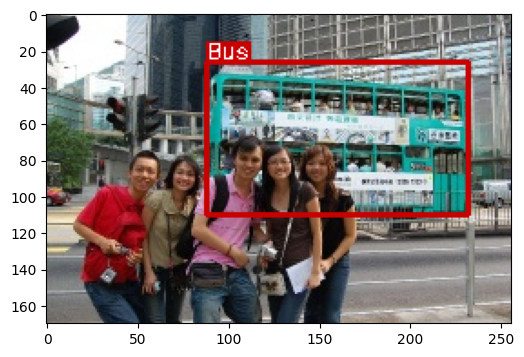

In [16]:
canvas = visualize(image, unnorm_bboxes, class_ids)
plt.figure(figsize=(6, 6))
plt.imshow(canvas)
plt.show()

In [17]:
@interact(index=(0, len(image_files)-1))
def show_sample(index=0):
    image_file = image_files[index]
    image_path = os.path.join('./DataSet/train/', image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image_id = image_file.split('.')[0]
    meta_data = data_df[data_df['ImageID'] == image_id]
    cate_names = meta_data['LabelName'].values
    bboxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
    img_H, img_W, _ = image.shape
    class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]
    
    unnorm_bboxes = bboxes.copy()
    unnorm_bboxes[:, [1, 2]] = unnorm_bboxes[:, [2, 1]]
    unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]
    unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4]/2)
    
    unnorm_bboxes[:, [0, 2]] *= img_W
    unnorm_bboxes[:, [1, 3]] *= img_H
    
    canvas = visualize(image, unnorm_bboxes, class_ids)
    plt.figure(figsize=(6, 6))
    plt.imshow(canvas)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=13702), Output()), _dom_classes=('widget-int…

In [18]:
class Detection_dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.data_dir = data_dir
        self.phase = phase
        self.data_df = pd.read_csv(os.path.join(self.data_dir, 'df.csv'))
        self.image_files = [fn for fn in os.listdir(os.path.join(self.data_dir, phase)) if fn.endswith('jpg')]
        self.transformer = transformer
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, index):
        filename, image = self.get_image(index)
        bboxes, class_ids = self.get_label(filename)
        img_H, img_W, _ = image.shape
        if self.transformer:
            image = self.transformer(image)
            _, img_H, img_W = image.shape
            
        bboxes[:, [0, 2]] *= img_W
        bboxes[:, [1, 3]] *= img_H
        
        target = {}
        target['boxes'] = torch.Tensor(bboxes).float()
        target['labels'] = torch.Tensor(class_ids).long()
        
        return image, target, filename
    
    def get_image(self, index):
        filename = self.image_files[index]
        image_path = os.path.join(self.data_dir, self.phase, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return filename, image
    
    def get_label(self, filename):
        image_id = filename.split('.')[0]
        meta_data = data_df[data_df['ImageID'] == image_id]
        cate_names = meta_data['LabelName'].values
        class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]
        
        bboxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
        bboxes[:, [1, 2]] = bboxes[:, [2, 1]]
        return bboxes, class_ids

In [19]:
data_dir = './DataSet/'
dataset = Detection_dataset(data_dir=data_dir, phase='train', transformer=None)

In [20]:
dataset[0]

(array([[[ 80,  87,  80],
         [ 86,  93,  86],
         [ 93,  95,  94],
         ...,
         [ 93,  91,  94],
         [ 77,  78,  82],
         [121, 125, 128]],
 
        [[ 79,  83,  82],
         [ 76,  80,  79],
         [ 79,  83,  84],
         ...,
         [ 82,  80,  83],
         [ 92,  93,  95],
         [121, 125, 126]],
 
        [[ 74,  74,  82],
         [ 68,  71,  78],
         [ 71,  74,  79],
         ...,
         [ 85,  83,  84],
         [ 98, 100,  99],
         [116, 122, 120]],
 
        ...,
 
        [[106, 102,  99],
         [108, 104, 101],
         [108, 104, 101],
         ...,
         [165, 157, 144],
         [150, 142, 129],
         [133, 125, 112]],
 
        [[108, 103,  99],
         [103,  98,  94],
         [111, 108, 103],
         ...,
         [166, 160, 148],
         [160, 154, 142],
         [151, 145, 133]],
 
        [[117, 112, 108],
         [116, 111, 107],
         [122, 119, 114],
         ...,
         [173, 167, 155],
  

In [21]:
index = 20
image, target, filename = dataset[index]

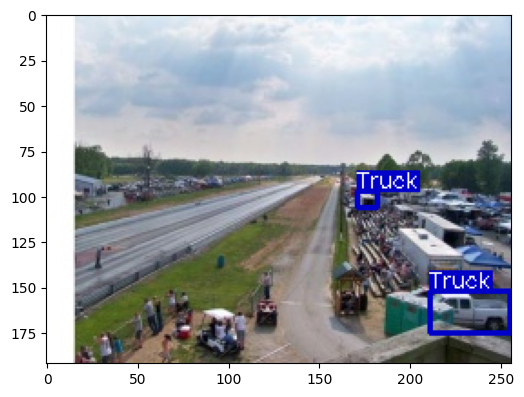

In [22]:
boxes = target['boxes'].numpy()
class_ids = target['labels'].numpy()

n_obj = boxes.shape[0]
bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
bboxes[:, 0:2] = (boxes[:, 0:2] + boxes[:, 2:4]) / 2
bboxes[:, 2:4] = boxes[:, 2:4] - boxes[:, 0:2]

canvas = visualize(image, bboxes, class_ids)

plt.figure(figsize=(6, 6))
plt.imshow(canvas)
plt.show()

In [23]:
@interact(index=(0, len(image_files)-1))
def show_sample(index=0):
    image, target, filename = dataset[index]
    
    boxes = target['boxes'].numpy()
    class_ids = target['labels'].numpy()

    n_obj = boxes.shape[0]
    bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
    bboxes[:, 0:2] = (boxes[:, 0:2] + boxes[:, 2:4]) / 2
    bboxes[:, 2:4] = boxes[:, 2:4] - boxes[:, 0:2]

    canvas = visualize(image, bboxes, class_ids)

    plt.figure(figsize=(6, 6))
    plt.imshow(canvas)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=13702), Output()), _dom_classes=('widget-int…

In [24]:
IMAGE_SIZE = 448
# [0.48 5, 0.456, 0.406],[0.229, 0.224, 0.225]값을 줬을 때 가장 성능이 좋다라는 논문이 있음
# Faster R-CNN 사용 시 pre-trained으로 사용된 이미지넷 데이터셋의 학습 시에 얻어낸 값
 
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) # 평균, 표준편차... 데이터 사이를 스케일링.
])

In [25]:
transformed_dataset = Detection_dataset(data_dir=data_dir, phase='train', transformer = transformer)

In [26]:
index = 0
image, target, filename = transformed_dataset[index]
image.shape

torch.Size([3, 448, 448])

In [27]:
np_image = make_grid(image, normalize=True).cpu().permute(1,2,0).numpy()
np_image.shape

(448, 448, 3)

In [28]:
boxes = target['boxes'].numpy()
class_ids = target['labels'].numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


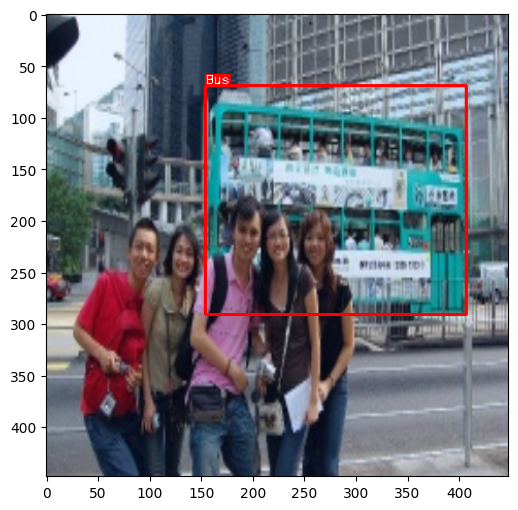

In [29]:
n_obj = boxes.shape[0]
bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
bboxes[:, 0:2] = (boxes[:, 0:2] + boxes[:, 2:4]) / 2
bboxes[:, 2:4] = boxes[:, 2:4] - boxes[:, 0:2]

canvas = visualize(np_image, bboxes, class_ids)

plt.figure(figsize=(6, 6))
plt.imshow(canvas)
plt.show()
# 머신러닝에서는 사진이 찌그러져도 detection하는데는 문제가 되지 않는다.

In [30]:
#collate_fn: DataLoader에서 데이터를 배치 사이즈씩 나누고, 각 배치에 대하여 해당 함수를 실행한 후에 반환하라고 하는 콜백함수.
def collate_fn(batch):
    image_list = []
    target_list = []
    filename_list = []
    
    for img, target, filename in batch:
        image_list.append(img)
        target_list.append(target)
        filename_list.append(filename)
        
    return image_list, target_list, filename_list    

In [31]:
BATCH_SIZE = 8 #2의 배수로 주는게 좋음

trainset = Detection_dataset(data_dir = data_dir, phase = 'train', transformer = transformer)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [32]:
for index, batch in enumerate(trainloader):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]
    
    if index == 0:
        break
        
print(targets)
print(filenames)

[{'boxes': tensor([[ 98.5600, 169.8668, 229.8800, 307.2532]]), 'labels': tensor([0])}, {'boxes': tensor([[ 12.8800,  13.0099, 438.7600, 432.7272]]), 'labels': tensor([0])}, {'boxes': tensor([[  0.0000, 193.0132, 154.0000, 356.5332]]), 'labels': tensor([1])}, {'boxes': tensor([[  0.0000, 151.9468,  39.7600, 335.6268],
        [  4.4800, 122.4532, 268.8000, 378.9332],
        [120.6800,  16.8000, 405.4400, 447.6268],
        [334.8800, 272.9068, 419.4400, 314.7200],
        [417.7600,  20.1600, 447.7200, 444.2668]]), 'labels': tensor([0, 0, 0, 0, 0])}, {'boxes': tensor([[111.4400, 140.3732, 351.1200, 300.1600]]), 'labels': tensor([1])}, {'boxes': tensor([[ 11.2000, 162.5160, 432.6000, 288.5738],
        [ 15.4000,  16.9931, 437.3600, 144.2869],
        [251.1600, 306.8029, 344.9600, 436.5684],
        [354.7600, 311.4370, 434.0000, 434.0968]]), 'labels': tensor([0, 0, 0, 0])}, {'boxes': tensor([[ 60.7600, 124.5113, 337.6800, 348.7115],
        [  6.1600, 266.2379,  15.9600, 277.0472],
  

In [33]:
def build_dataloader(data_dir, batch_size=4, image_size=448):
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    dataloaders = {}
    train_dataset = Detection_dataset(data_dir=data_dir, phase='train', transformer=transformer)
    dataloaders['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    
    val_dataset = Detection_dataset(data_dir=data_dir, phase='val', transformer=transformer)
    dataloaders['val'] = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    return dataloaders

In [34]:
data_dir = './DataSet/'
dloaders = build_dataloader(data_dir)
# train모드 4바퀴, val 1바퀴. 배치가 하나니깐.
for phase in ['train', 'val']:
    for index, batch in enumerate(dloaders[phase]):
        images = batch[0]
        targets = batch[1]
        filenames = batch[2]
        print(f'{phase}: {targets}')
        if index == 0:
            break
 

train: [{'boxes': tensor([[112.0000, 248.7332, 180.9499, 309.8668]]), 'labels': tensor([1])}, {'boxes': tensor([[137.4800,  50.0268, 374.3600, 386.4000]]), 'labels': tensor([0])}, {'boxes': tensor([[  0.0000,   4.6229, 220.3600, 447.5798],
        [122.6400, 169.3660, 183.6800, 242.4917],
        [175.0000, 157.1781, 274.4000, 310.5742],
        [244.4400, 127.3395, 447.7200, 339.1521],
        [348.8800, 140.7880, 446.0400, 347.5571]]), 'labels': tensor([1, 1, 1, 1, 1])}, {'boxes': tensor([[204.4000, 245.6998, 403.2000, 348.6000]]), 'labels': tensor([1])}]
val: [{'boxes': tensor([[ 80.9200, 186.5965, 303.5200, 393.7862]]), 'labels': tensor([1])}]


In [35]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [36]:
# 모델 수정해주는 함수
def build_model(num_classes):
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [37]:
NUM_CLASSES = 2
model = build_model(num_classes = NUM_CLASSES)
model
# 8은 2개 객체당 각각 4개의 좌표값을 말하는것이라서, 바운딩박스 2개의 총 좌표가 8개여서 out_features가 8인것
# 아래처럼 2개의 레이어가, 하나의 out_features가 다음 레이어의 in_features와 다른경우는, 두개가 연속적으로 이어진 레이어가 아니고,
# 각각 값을 받아서 out_features를 반환함. 따라서 이 모델의 예측값은 cls_score, bbox_pred 2가지의 값이 리스트에 담겨서 반환됨.
#     (box_predictor): FastRCNNPredictor(
#      (cls_score): Linear(in_features=1024, out_features=2, bias=True)
#      (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [38]:
phase = 'train'
model.train()

for index, batch in enumerate(dloaders[phase]):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]

    images = list(image for image in images)
    targets = [{k: v for k, v in t.items()} for t in targets]

    loss = model(images, targets)
    if index == 0:
        break
            
loss

'''

# 클래스를 구분하는 스테이지
loss_classifier
loss_box_reg

# 오브젝트가 존재하는지 여부 스테이지
loss_objectness
loss_rpn_box_reg

'''

'\n\n# 클래스를 구분하는 스테이지\nloss_classifier\nloss_box_reg\n\n# 오브젝트가 존재하는지 여부 스테이지\nloss_objectness\nloss_rpn_box_reg\n\n'

In [39]:
def train_one_epoch(dataloaders, model, optimizer, device):
    train_loss = defaultdict(float)
    val_loss = defaultdict(float)
    model.train()
    
    for phase in ['train', 'val']:
        for index, batch in enumerate(dloaders[phase]):
            images = batch[0]
            targets = batch[1]
            filenames = batch[2]
            
            images = list(image for image in images)
            targets = [{k: v for k, v in t.items()} for t in targets]
            
            with torch.set_grad_enabled(phase == 'train'):
                loss = model(images, targets)
                
            total_loss = sum(each_loss for each_loss in loss.values())
            
            if phase == 'train':
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()
                
                if (index > 0) and (index % VERBOSE_FREQ) == 0:
                    text = f"{index}/{len(dataloaders[phase])} - "
                    for k, v in loss.items():
                        text += f'{k}: {v.item():.4f}'
                    print(text)
                    
                for k, v in loss.items():
                    train_loss[k] += v.item()
                train_loss['total_loss'] += total_loss.item()
            else:
                for k, v in loss.item():
                    val_loss[k] += v.item()
                val_loss['total_loss'] += total_loss.item()
                
    for k in train_loss.keys():
        train_loss[k] /= len(dataloaders['train'])
        val_loss[k] /= len(dataloaders['val'])
    return train_loss, val_loss

In [40]:
data_dir = './DataSet/'
is_cuda = False

NUM_CLASSES = 2
IMAGE_SIZE = 448
BATCH_SIZE = 8
VERBOSE_FREQ = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')

dataloaders = build_dataloader(data_dir=data_dir, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)
model = build_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
num_epochs = 30

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_losses, val_losses = train_one_epoch(dataloaders, model, optimizer, DEVICE)
    train_losses.append(train_losses)
    val_losses.append(val_losses)
    
    print(f"epoch:{epoch+1}/{num_epochs} - Train Loss: {train_loss['total_loss']:.4f}, Val Loss: {val_loss['total_loss']:.4f}")
    
    if(epoch+1) % 10 == 0:
        save_model(model.stat_dict(), f'model_{epoch+1}.pth')

100/1713 - loss_classifier: 0.0845loss_box_reg: 0.1104loss_objectness: 0.0165loss_rpn_box_reg: 0.0066


In [ ]:
tr_loss_classifier = []
tr_loss_box_reg = []
tr_loss_objectness = []
tr_loss_rpn_box_reg = []
tr_loss_total = []
for tr_loss in train_losses:
    tr_loss_classifier.append(tr_loss['loss_classifier'])
    tr_loss_box_reg.append(tr_loss['loss_box_reg'])
    tr_loss_objectness.append(tr_loss['loss_objectness'])
    tr_loss_rpn_box_reg.append(tr_loss['loss_rpn_box_reg'])
    tr_loss_total.append(tr_loss['total_loss'])
val_loss_classifier = []
val_loss_box_reg = []
val_loss_objectness = []
val_loss_rpn_box_reg = []
val_loss_total = []
for vl_loss in val_losses:
    val_loss_classifier.append(vl_loss['loss_classifier'])
    val_loss_box_reg.append(vl_loss['loss_box_reg'])
    val_loss_objectness.append(vl_loss['loss_objectness'])
    val_loss_rpn_box_reg.append(vl_loss['loss_rpn_box_reg'])
    val_loss_total.append(vl_loss['total_loss'])
plt.figure(figsize=(8, 4))
plt.plot(tr_loss_total, label="train_total_loss")
plt.plot(tr_loss_classifier, label="train_loss_classifier")
plt.plot(tr_loss_box_reg,  label="train_loss_box_reg")
plt.plot(tr_loss_objectness, label="train_loss_objectness")
plt.plot(tr_loss_rpn_box_reg,  label="train_loss_rpn_box_reg")
plt.plot(val_loss_total, label="train_total_loss")
plt.plot(val_loss_classifier, label="val_loss_classifier")
plt.plot(val_loss_box_reg,  label="val_loss_box_reg")
plt.plot(val_loss_objectness, label="val_loss_objectness")
plt.plot(val_loss_rpn_box_reg,  label="val_loss_rpn_box_reg")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend(loc='upper right')
plt.tight_layout()

In [ ]:
def load_model(ckpt_path, num_classes, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = build_model(num_classes=num_classes)
    model.load_state_dict(checkpoint)
    model = model.to(device)
    model.eval()
    return model

In [ ]:
model = load_model(ckpt_path='./trained_model/model_30.pth', num_classes=NUM_CLASSES, device=DEVICE)
model

### Confidence Threshold
* 객체 탐지와 같은 작업에서 사요오디는 개념
* 객체 탐지 모델은 입력 이미지에서 객체의 위치를 찾아내는 작업을 수행 -> 모델은 주어진 이미지 내에서 다양한 위치에 대해 객체가 존재하는지 예측하고 각 객체에 대한 바운딩 박스와 해당 객체에 대한 신뢰도(confidence score)를 출력
* 신뢰도를 조절하는 기준값
* 예) Confidence Threshold을 0.8로 설정하면 모델은 신뢰도가 0.8이상인 객체만을 선택하게 됨
* Confidence Threshold를 적절하게 설정해야 객체 탐지의 정확도를 높일 수 있음
    * 너무 낮은 Confidence Threshold를 설정하면 신회성이 낮은 결과를 포함
    * 너무 높은 Confidence Threshold를 설정하면 신뢰성이 높은 객체조차 누락

<img src='https://blog.kakaocdn.net/dn/96Xcc/btrAaVSmJqg/K69oluJU7oCqNHntQ8wh20/img.png'>

### Non-Maximum Suppression(NMS)
* 중복된 결과를 제거하여 정확하고 겹치지 않는 객체를 식별하는 데 사용
* NMS가 작동되는 순서
    * 객체 탐지 모델 실행(이미지를 입력받아 바운딩 박스와 신뢰도를 출력)
    * 바운딩 박스 필터링(겹치는 바운딩 박스들 중에서 가장 확실한 바운딩 박스만 남기고 나머지 겹치는 바운딩 박스를 제거, IoU 지표를 사용)

### IoU(Intersection over Union)
* 객체 탐지나 세드멘테이션과 같은 컴퓨터 비전에서 모델이 예측한 결과와 실제 라벨 사이의 정확도를 측정하는 지표
* 바운딩 박스나 세그멘테이션 마스크가 얼마나 겹치는지를 측정하여, 예측 결과의 정확성을 평가하는데 사용
* 0과 1사이의 값으로 1에 가까울수록 예측 결과가 정확하고 겹치는 영역이 많다는 것을 의미
* 계산 방법
    * 영역 A와 영역 B의 겹치는 영역 계산. 공통 부분을 계산
    * 교집합 계산(얼마나 겹쳐져 있는지)
    * 합집합 계산(두 영역의 전체 크기)
    * IoU계산(교집합을 합집합으로 나눔. 교집합/합집합)

In [ ]:
def postprocess(prediction, conf_thres=0.3, IoU_threshold=0.2):
    pred_box = prediction['boxes'].cpu().detach().numpy()
    pred_label = prediction['labels'].cpu().detach().numpy()
    pred_conf = prediction['scores'].cpu().detach().numpy()
    
    valid_index = pred_conf > conf_thres
    pred_box = pred_box[valid_index]
    pred_label = pred_label[valid_index]
    pred_conf = pred_conf[valid_index]
    
    valid_index = nms(torch.tensor(pred_box.astype(np.float32)), torch.tensor(pred_conf), IoU_threshold)
    pred_box = pred_box[valid_index.numpy()]
    pred_label = pred_label[valid_index.numpy()]
    pred_conf = pred_conf[valid_index.numpy()]
    return np.concatenate((pred_box, pred_conf[:, np.newaxis], pred_label[:, np.newaxis]), axis=1)

In [ ]:
pred_images = []
pred_labels = []

for index, (images, _, filenames) in enumerate(dataloaders['val']):
    images = list(image.to(DEVICE) for image in images)
    filename = filenames[0]
    
    image = make_grid(images[0].cpu().detach(), normalize=True).permute(1, 2, 0).numpy()
    image = (image * 255).astype(np.uint8)
    
    with torch.no_grad():
        prediction = model(images)
        
    prediction = postprocess(prediction[0])
    prediction[:, 2].clip(min=0, max=image.shape[1])
    prediction[:, 3].clip(min=0, max=image.shape[0])
    
    xc = (prediction[:, 0] + prediction[:, 2])/2
    yc = (prediction[:, 1] + prediction[:, 3])/2
    w = prediction[:, 2] - prediction[:, 0]
    h = prediction[:, 3] - prediction[:, 1]
    cls_id = prediction[:, 5]
    prediction_yolo = np.stack([xc, yc, w, h, cls_id], axis=1)
    
    pred_images.append(image)
    pred_labels.append(prediction_yolo)
    
    if index == 2:
        break

In [ ]:
pred_labels

In [ ]:
@interact(index=(0, len(pred_images)-1))
def show_result(index=0):
    result = visualize(pred_images[index], pred_labels[index][:, 0:4], pred_labels[index][:, 4])
    plt.figure(figsize=(6, 6))
    plt.imshow(result)
    plt.show()

In [ ]:
video_path = './sample_video.mp4'

In [ ]:
@torch.no_grad()
def model_predict(image, model):
    tensor_image = transformer(image)
    tensor_image = tensor_image.to(DEVICE)
    prediction = model([tensor_image])
    return prediction

In [ ]:
video = cv2.VideoCapture(video_path)

while(video.isOpened()):
    ret, frame = video.read()
    
    if ret:
        ori_h, ori_w = frame.shape[:2]
        image = cv2.resize(frame, dsize=(IMAGE_SIZE, IMAGE_SIZE))
        prediction = model_predict(image, model)
        prediction = postprocess(prediction[0])
        prediction[:, [0, 2]] *= (ori_w / IMAGE_SIZE)
        prediction[:, [1, 3]] *= (ori_h / IMAGE_SIZE)
        prediction[:, 2].clip(min=0, max=image.shape[1])
        prediction[:, 3].clip(min=0, max=image.shape[0])
        
        xc = (prediction[:, 0] + prediction[:, 2]) / 2
        yc = (prediction[:, 1] + prediction[:, 3]) / 2
        w = prediction[:, 2] - prediction[:, 0]
        h = prediction[:, 3] - prediction[:, 1]
        cls_id = prediction[:, 5]
        prediction_yolo = np.stack([xc, yc, w, h, cls_id], axis=1)
        
        canvas = visualize(frame, prediction_yolo[:, 0:4], prediction_yolo[:, 4])
        cv2.imshow('camera', canvas)
        
        key = cv2.waitKey(1)
        if key == 27:
            break
        if key == ord('s'):
            cv2.waitKey()
            
video.release()

# 4. One-Stage 모델
* Region Proposal과 detection이 한 번에 수행
* YOLO(You only Look Once)
    * 2015년 제안된 객체 검출 모델로 이미지 전체를 단일 그리드로 나누고, 각 그리드 셀마다 여러 개의 바운딩 박스와 클래스를 예측하는 방식
    
<img src='https://velog.velcdn.com/images%2Fraziel%2Fpost%2F901df3ee-6aaf-468b-9991-072aeed00381%2Fimage.png' width=600>
    
* SSD(Single shot Detector)
    * 2016년에 제안된 객체 검출 모델로, 다양한 스케일의 바운딩 박스와 클래스를 동시에 예측하는 방식
    * 다양한 특징 맵에서 바운딩 박스를 예측하므로 다양한 크기의 객체를 잘 탐지할 수 있음

### 4-1. Multi-Scale Feature Layer
* 여러 번의 컨볼루션을 적용해 나온 여러 개의 Feature Map을 Object Detection을 수행시키고 그 결과를 통합해 최종 Detection 하는 과정
* https://techblog-history-younghunjo1.tistory.com/185

### 4-2. Default Box(Anchor Box)
* 컨볼루션을 통해 나온 각각의 Feature map의 포인트마다 여러 개의 anchor box를 씌우고 ground truth와 비교를 하면서 학습 진행
* https://towardsdatascience.com/yolov1-you-only-look-once-object-detection-e1f3ffec8a89